In [1]:
import ijson
import json
import pymongo
from tqdm import tqdm


import chemdataextractor as CDE
from chemdataextractor.doc import Paragraph
import pandas as pd
import re
import numpy as np
def get_paper():
    f = open("solution-synthesis_dataset_2021-8-5.json", "r", encoding="utf-8")
    yield from ijson.items(f, "item")
    
    
def clean_ion_dict(ion_dict):
    # merge CH3COO -> Ac in precursor dict
    if 'CH3COO' in ion_dict.keys():
        if 'Ac' in ion_dict.keys():
            ion_dict['Ac'] += ion_dict['CH3COO']
        else:
            ion_dict['Ac'] = ion_dict['CH3COO']
        ion_dict.pop('CH3COO')
    return ion_dict
    
    
elements = set(
    'He|'
    'Li|Be|B|C|N|F|Ne|'
    'Na|Mg|Al|Si|P|S|Cl|Ar|'
    'K|Ca|Sc|Ti|V|Cr|Mn|Fe|Co|Ni|Cu|Zn|Ga|Ge|As|Se|Br|Kr|'
    'Rb|Sr|Y|Zr|Nb|Mo|Tc|Ru|Rh|Pd|Ag|Cd|In|Sn|Sb|Te|I|Xe|'
    'Cs|Ba|La|Ce|Pr|Nd|Pm|Sm|Eu|Gd|Tb|Dy|Ho|Er|Tm|Yb|Lu|Hf|Ta|W|Re|Os|Ir|Pt|Au|Hg|Tl|Pb|Bi|Po|At|Rn|'
    'Fr|Ra|Ac|Th|Pa|U|Np|Pu|Am|Cm|Bk|Cf|Es|Fm|Md|No|Lr|Rf|Db|Sg|Bh|Hs|Mt|Ds|Rg'.split('|')
)

import re
list_of_elements_1 = ['H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'K', 'V', 'Y', 'I', 'W', 'U']
list_of_elements_2 = ['He', 'Li', 'Be', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'Cl', 'Ar', 'Ca', 'Sc', 'Ti', 'Cr',
                      'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr',
                      'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'Xe',
                      'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er',
                      'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi',
                      'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf',
                      'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn',
                      'Fl', 'Lv']
list_of_elements = list_of_elements_1+list_of_elements_2

def build_formula(m_struct):
    formula = ''
    if len(m_struct['composition']) == 1:
        return m_struct['composition'][0]['formula']
    
    coeff = ''
    for c in m_struct['composition']:
        if c['amount'] in ['1.0', '1']:
            coeff = ''
        elif all(ch.isdigit() or ch == '.' for ch in c['amount']):
            coeff = c['amount']
        else:
            coeff = '('+c['amount']+')'
            
        formula = formula + '-'+coeff+c['formula']
        
    return formula.lstrip('-')

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

from pymatgen.core.periodic_table import Element

import math
import numpy as np

import matplotlib.pyplot as plt

from pymatgen.core.periodic_table import Element

def periodic_table(elemental_data, cbar_label="",
                           show_plot=False, cmap="YlOrRd", blank_color="grey",
                           value_format=None, max_row=9):
    """
    A static method that generates a heat map overlapped on a periodic table.

    Args:
         elemental_data (dict): A dictionary with the element as a key and a
            value assigned to it, e.g. surface energy and frequency, etc.
            Elements missing in the elemental_data will be grey by default
            in the final table elemental_data={"Fe": 4.2, "O": 5.0}.
         cbar_label (string): Label of the colorbar. Default is "".
         figure_name (string): Name of the plot (absolute path) being saved
            if not None.
         show_plot (bool): Whether to show the heatmap. Default is False.
         value_format (str): Formatting string to show values. If None, no value
            is shown. Example: "%.4f" shows float to four decimals.
         cmap (string): Color scheme of the heatmap. Default is 'coolwarm'.
         blank_color (string): Color assigned for the missing elements in
            elemental_data. Default is "grey".
         max_row (integer): Maximum number of rows of the periodic table to be
            shown. Default is 9, which means the periodic table heat map covers
            the first 9 rows of elements.
    """

    # Convert primitive_elemental data in the form of numpy array for plotting.
    max_val = max(elemental_data.values())
    min_val = min(elemental_data.values())
    max_row = min(max_row, 9)

    if max_row <= 0:
        raise ValueError("The input argument 'max_row' must be positive!")

    value_table = np.empty((max_row, 18)) * np.nan
    blank_value = min_val - 0.01

    for el in Element:
        if el.row > max_row: continue
        value = elemental_data.get(el.symbol, blank_value)
        value_table[el.row - 1, el.group - 1] = value

    # Initialize the plt object
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    plt.gcf().set_size_inches(18, 12)

    # We set nan type values to masked values (ie blank spaces)
    data_mask = np.ma.masked_invalid(value_table.tolist())
    heatmap = ax.pcolor(data_mask, cmap=cmap, edgecolors='w', linewidths=1,
                        vmin=min_val-0.001, vmax=max_val+0.001)
#     cbaxes = fig.add_axes([0.35, 0.8, 0.4, 0.03]) 
#     cbar = fig.colorbar(heatmap, orientation="horizontal", cax = cbaxes)
    cbar = fig.colorbar(heatmap)
    # Grey out missing elements in input data
    cbar.cmap.set_under(blank_color)
    cbar.set_label(cbar_label, rotation=270, labelpad=15)
    cbar.ax.tick_params(labelsize=14)

    # Refine and make the table look nice
    ax.axis('off')
    ax.invert_yaxis()

    # Label each block with corresponding element and value
    for i, row in enumerate(value_table):
        for j, el in enumerate(row):
            if not np.isnan(el):
                symbol = Element.from_row_and_group(i+1, j+1).symbol
                plt.text(j + 0.5, i + 0.25, symbol,
                         horizontalalignment='center',
                         verticalalignment='center', fontsize=14)
                if el != blank_value and value_format is not None:
                    plt.text(j + 0.5, i + 0.5, value_format % el,
                             horizontalalignment='center',
                             verticalalignment='center', fontsize=10)

    plt.tight_layout()

    if show_plot:
        plt.show()

    return plt

In [3]:
group = [['' for j in range(5)] for i in range(18)]
group[1] = ['Li', 'Na', 'K', 'Rb', 'Cs', 'La']
group[2] = ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ce']
group[3] = ['', '', 'Sc', 'Y', '', 'Pr']
group[4] = ['', '', 'Ti', 'Zr', 'Hf', 'Nd']
group[5] = ['', '', 'V', 'Nb', 'Ta', 'Pm']
group[6] = ['', '', 'Cr', 'Mo', 'W', 'Sm']
group[7] = ['', '', 'Mn', 'Tc', 'Re', 'Eu']
group[8] = ['', '', 'Fe', 'Ru', 'Os', 'Gd']
group[9] = ['', '', 'Co', 'Rh', 'Ir', 'Tb']
group[10] = ['', '', 'Ni', 'Pd', 'Pt', 'Dy']
group[11] = ['', '', 'Cu', 'Ag', 'Au', 'Ho']
group[12] = ['', '', 'Zn', 'Cd', 'Hg', 'Er']
group[13] = ['B', 'Al', 'Ga', 'In', 'Tl', 'Tm']
group[14] = ['', 'Si', 'Ge', 'Sn', 'Pb', 'Yb']
group[15] = ['', '', 'As', 'Sb', 'Bi', 'Lu']
group[16] = ['O', 'S', 'Se', 'Te', 'Po', '']
group[17] = ['F', 'Cl', 'Br', 'I', 'At', '']



valid_elements = [el for g in group[:-2] for el in g if el != '']


tickfont_x = dict(size=22, color='black')
tickfont_y = dict(size=22, color='black')
color_groups = {
    'O': 'rgba(255, 0, 0, 1.0)',
    'CO3': 'rgba(255, 0, 0, 0.75)',
    'NO3': 'rgba(255, 0, 0, 0.5)',
    'HCO3': 'rgba(255, 0, 0, 0.25)',
    'PO3': 'rgba(253, 129, 4, 1.0)',
    'PO4': 'rgba(253, 129, 4, 0.75)',
    'H2PO4': 'rgba(253, 129, 4, 0.50)',
    'OH': 'rgba(46, 206, 3, 1.0)',
    'C2O4': 'rgba(46, 206, 3, 0.75)',
    'Ac': 'rgba(46, 206, 3, 0.5)',
    'B': 'rgba(0, 0, 255, 1.0)',
    'C': 'rgba(0, 0, 255, 0.75)',
    'N': 'rgba(0, 0, 255, 0.5)',
    'S': 'rgba(0, 0, 255, 0.25)',
    'SO4': 'rgba(110, 9, 244, 1.0)',
    'F': 'rgba(110, 9, 244, 0.75)',
    'Cl': 'rgba(110, 9, 244, 0.5)',
    'NH4': 'rgba(110, 9, 244, 0.25)',
    'Elem': 'rgba(255, 0, 239, 1.0)'
}

In [4]:
target_element_frequency = {}
for i, paper in tqdm(enumerate(get_paper())):
    target = paper['target']
    if target['composition']:
        try:
            for target_comp in target['composition']:
                for element in target_comp['elements'].keys():
                    if element not in target_element_frequency.keys():
#                         print(parsed_target['composition'][0]['formula'])
                        target_element_frequency[element] = 1
                    else:
                        target_element_frequency[element] += 1
        except:
            continue
sorted_elements_frequency = sorted(target_element_frequency.items(), key=lambda x: x[1], reverse=True)
print(target_element_frequency)

35675it [00:03, 10196.49it/s]

{'La': 698, 'Ti': 3423, 'O': 31452, 'Co': 2541, 'Fe': 4848, 'Zn': 4944, 'Cu': 1697, 'S': 2768, 'Ag': 717, 'Pb': 370, 'Te': 260, 'Eu': 235, 'V': 1192, 'Mn': 2539, 'Ni': 2733, 'Li': 1324, 'C': 2163, 'Si': 1006, 'Y': 893, 'Zr': 1436, 'H': 5391, 'W': 1562, 'N': 1000, 'Yb': 98, 'Er': 60, 'Al': 1569, 'Sb': 178, 'F': 952, 'Cd': 1090, 'Mo': 1265, 'Se': 474, 'Cr': 249, 'Gd': 437, 'P': 2186, 'Na': 1043, 'Mg': 810, 'Ce': 882, 'In': 618, 'Sn': 1491, 'Sr': 555, 'Lu': 106, 'Cs': 161, 'Bi': 1869, 'Nb': 315, 'Ge': 127, 'Ba': 604, 'Au': 224, 'U': 101, 'Sm': 105, 'Hf': 46, 'Nd': 121, 'Ir': 51, 'Ru': 83, 'Cl': 548, 'Ca': 1014, 'Sc': 54, 'Ga': 267, 'Pt': 197, 'K': 244, 'Ta': 117, 'B': 290, 'Pd': 168, 'Br': 275, 'Rb': 72, 'Dy': 56, 'Th': 51, 'Tb': 97, 'Ho': 20, 'As': 63, 'Tl': 12, 'Re': 23, 'I': 176, 'Cf': 1, 'Hg': 40, 'Pr': 54, 'Tm': 16, 'Rh': 37, 'Be': 6, 'Pu': 6, 'Np': 8, 'Hs': 3, 'Ac': 1, 'Cm': 1, 'Tc': 1, 'Os': 2}


/Users/wangzheren/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))


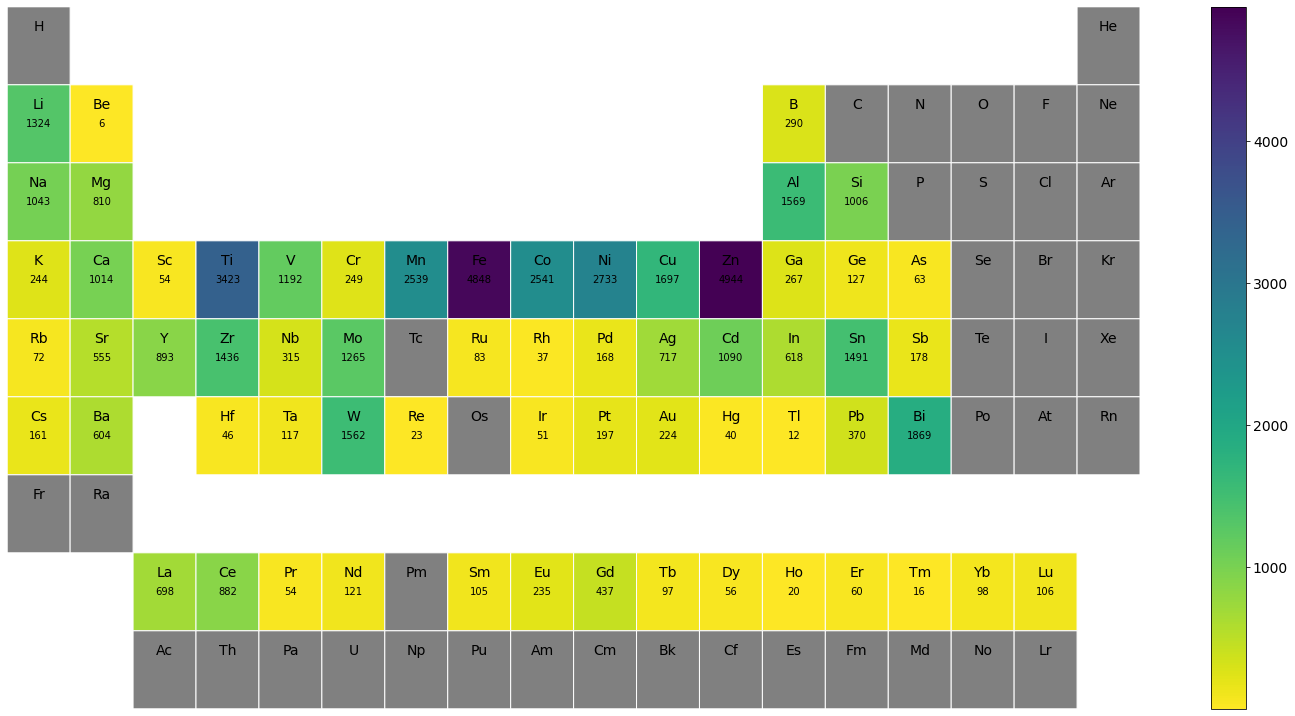

In [5]:
elements_freq_count = [{'element': el, 'target_count': count} for el, count in target_element_frequency.items() if count > 5 and el != 'O' and el != 'H']
dropped_elements = [el for el, count in target_element_frequency.items() if count <= 5 or el == 'O' or el == 'H']
elements_freq_count = {el: count for el, count in target_element_frequency.items() if count > 5 and el in valid_elements}
cmap_possible = ['summer_r', 'Wistia']
pt_plot = periodic_table(elements_freq_count, show_plot=False, cmap="viridis_r", value_format="%.0f")
figure = pt_plot.gcf()  # get current figure
figure.set_size_inches(20,10)

In [6]:
import plotly.graph_objs as go
import plotly.io as pio
import plotly
from plotly.subplots import make_subplots

In [7]:
sorted_elements_frequency = sorted(elements_freq_count.items(), key=lambda x: x[1], reverse=True)
# print(sorted_frequency_ppt)
target_elements_list = [p[0] for p in sorted_elements_frequency]
freqency_elements_list = [p[1] for p in sorted_elements_frequency]

In [8]:
common_ion = []
m_anions = ['H2PO4', 'HPO4', 'HCO3', 'HSO4', 'HSO3', 'C2O4']
d_anions = ['CO3', 'PO4', 'PO3', 'OH', 'NH4', 'NO3', 'NO2', 'SO4', 'SO3', 'CN']
s_anions = ['O', 'N', 'C', 'F', 'S', 'B', 'P']
# s_anions = ['O', 'F', 'S']
ions = m_anions + d_anions + s_anions + ['Cl'] + ['Org'] + ['Ac'] + ['Elem'] + ['Hydrate'] + ['others']
element_ion_frequency = {}
for element in list_of_elements:
    element_ion_frequency[element] = dict((ion,0) for ion in ions)

for i, paper in tqdm(enumerate(get_paper())):
    target = paper['target']
    if target['composition']:
        for target_comp in target['composition']:
            for element in target_comp['elements'].keys():
                if element in list_of_elements:
                    for precursor in paper['precursors']:
                        has_ion_listed = False
                        precursor_elements = set(e for c in precursor['composition'] for e in c['elements'].keys() if e in list_of_elements) 
                        num_elemts = len(set(e for c in precursor['composition'] for e in c['elements'].keys()))
                        if element not in precursor_elements:
                            continue
                        formula = build_formula(precursor)
                        if element + 'NP' in formula:
                            element_ion_frequency[element]['Elem'] += 1
                            continue
                        if 'H2O' in formula[-3:]:
                            prec_formula = formula[:-3].rstrip('(⋅.*')
                            #precursors_ions_table['Hydrate'].append(prec_formula)
                            #prec_formula = ''
                        else:
                            prec_formula = formula.rstrip('(⋅.*')
                        prec = prec_formula
                        if prec_formula in list_of_elements and num_elemts == 1:
                            has_ion_listed = True
                            element_ion_frequency[element]['Elem'] += 1
                        a = 'CH3COO' 
                        if a in prec:
                            has_ion_listed = True
                            element_ion_frequency[element]['Ac'] += 1
                            prec = prec.replace(a, '')
                        if len(re.findall('C[HO]{1}', prec)) > 1 or 'OC2H5' in prec:
                            has_ion_listed = True
                            element_ion_frequency[element]['Org'] += 1
                        else:            
                            if precursor['composition']:
                                for precursor_comp in precursor['composition']:
                                    if element in precursor_comp['elements'].keys():
                                        if 'species' in precursor_comp.keys():
                                            if precursor_comp['species']:
                                                for spe in precursor_comp['species']:
                                                    if spe not in ions:
                                                        continue
                                                    else:

#                                                             if spe in s_anions: continue
                                                        has_ion_listed = True
                                                        if spe == 'C' and (len(re.findall('[a-zC][0-9H]{2,4}', prec)) >= 1 or 'CH' in prec and 'CO' not in prec):
                                                            element_ion_frequency[element]['Org'] += 1
                                                        elif spe == 'C' and 'CO' in formula:
                                                            continue
                                                        else:
                                                            element_ion_frequency[element][spe] += 1
                                            else:
                                                for a in m_anions+d_anions:
                                                    if a in prec:
                                                        has_ion_listed = True
                                                        element_ion_frequency[element][a] += 1
                                                        prec = prec.replace(a, '')

                                                prec_ = prec.rstrip('0987654321⋅.*')
                                                if len(prec_) > 0:
                                                    for a in s_anions:
                                                        if a == prec_[-1] and num_elemts == 2 and len(prec_[:-1]) > 1:
                                                            if a == 'C' and 'CO' in formula: continue
                                                            has_ion_listed = True
                                                            element_ion_frequency[element][a] += 1
                                                    if prec_[-2:] == 'Cl' and 'AuCl4' not in formula:
                                                        has_ion_listed = True
                                                        element_ion_frequency[element]['Cl'] += 1
                        if not has_ion_listed:
                            element_ion_frequency[element]['others'] += 1
for element in list_of_elements:
    element_ion_frequency[element] = clean_ion_dict(element_ion_frequency[element])

35675it [00:04, 7452.83it/s]


In [9]:
tickfont_x = dict(size=22, color='black')
tickfont_y = dict(size=22, color='black')

color_groups = {
    'O': "#d50000", #"#1f77b4", #'rgba(255, 0, 0, 1.0)',
    'CO3': "#c51162", # "#aec7e8", #'rgba(255, 0, 0, 0.75)',
    'NO3': "#aa00ff", #"#ff7f0e", #'rgba(255, 0, 0, 0.5)',
    'PO4': "#304ffe", # "#2ca02c", #'rgba(253, 129, 4, 1.0)',
    'H2PO4': "#2962ff", # "#98df8a", #'rgba(253, 129, 4, 0.75)',
    'OH': "#0091ea", #"#d62728", #'rgba(253, 129, 4, 0.50)',
    'C2O4': "#00c853", # "#00b8d4", #"#ff9896", #'rgba(46, 206, 3, 1.0)',
    'Ac': "#00bfa5", #"#9467bd", #'rgba(46, 206, 3, 0.75)',
    'S': "#ffab00",  #"#e377c2", #'rgba(0, 0, 255, 0.5)',
    'SO3': "#ff6d00", #"#f7b6d2", #'rgba(0, 0, 255, 0.25)',
    "SO4": "#9edae5",
    'F': "#dd2c00", # "#7f7f7f", #'rgba(110, 9, 244, 1.0)',
    'Cl': "#c7c7c7", #'rgba(110, 9, 244, 0.75)',
    'NH4': "#3e2723",  #"#bcbd22", #'rgba(110, 9, 244, 0.5)',
    'Org': "#212121", # "#dbdb8d", #'rgba(110, 9, 244, 0.25)',
    'others': "#263238", #"#17becf",#'rgba(255, 0, 239, 1.0)',
}

print(len(color_groups))

16


In [10]:
color_groups.values()
color_groups_values = ["#ff6d00", "#dd2c00", "#b71c1c", "#d50000", "#c51162", "#880e4f", "#aa00ff", "#6200ea", "#304ffe", "#01579b", 
                       "#2962ff", "#0091ea", "#33691e", "#00bfa5", "#00c853", "#64dd17",
                      "#aeea00", "#ffd600","#ffab00"]

ions = list(color_groups.keys())
# for i in range(20):
for i in range(16):
    color_groups[ions[i]] = color_groups_values[18-i]

In [11]:
color_groups

{'O': '#ffab00',
 'CO3': '#ffd600',
 'NO3': '#aeea00',
 'PO4': '#64dd17',
 'H2PO4': '#00c853',
 'OH': '#00bfa5',
 'C2O4': '#33691e',
 'Ac': '#0091ea',
 'S': '#2962ff',
 'SO3': '#01579b',
 'SO4': '#304ffe',
 'F': '#6200ea',
 'Cl': '#aa00ff',
 'NH4': '#880e4f',
 'Org': '#c51162',
 'others': '#d50000'}

In [12]:
el_ions = [ion for ion in reversed([c for c in color_groups.keys()])] #[c for c in color_groups.keys()]
bars_colors = [c for c in reversed(list(color_groups.values()))]
for el in element_ion_frequency:
    for ion in element_ion_frequency[el]:
        if ion not in el_ions:
            element_ion_frequency[el]['others'] += element_ion_frequency[el][ion]

In [ ]:
num_rows = 6
num_cols = 15

subplot_titles = [group[g][row] for row in range(num_rows) for g in range(1,num_cols+1)]

freq_fig = make_subplots(rows=num_rows, cols=num_cols, 
                           subplot_titles=subplot_titles, 
                           horizontal_spacing = 0.001,
                           vertical_spacing=0.05,
                           shared_xaxes=False)


el_ions = [ion for ion in reversed([c for c in color_groups.keys()])] #[c for c in color_groups.keys()]
bars_colors = [c for c in reversed(list(color_groups.values()))]

for g in range(1,num_cols+1):
    group_elms = group[g] #[e for e in reversed(group[g])]
    
    #print(group_elms)

    bars_chart = []
    for row, el in enumerate(group_elms): 
        #print(el, row, g, g+(num_cols)*row)
        data_z = np.zeros(len(el_ions))
        texts = ['' for i in range(len(el_ions))]
        if el != '':
            for i, ion in enumerate(el_ions):
                if element_ion_frequency[el][ion] < 5:
                    texts[i] = 'M'
                    
                if element_ion_frequency[el][ion] > 0:
                    data_z[i] = element_ion_frequency[el][ion]
            freq_fig['layout']['xaxis'+str(g+(num_cols)*row)].update(range=[0,0.25],
                                                               ticks='',
                                                               showline=True,
                                                               tick0=-0.1,
                                                               dtick=0.3,
                                                               ticktext=['0', '20'],
                                                               showticklabels=row == num_rows-1,# or g == 1 and row == 4,
                                                               linewidth=3,
                                                               gridwidth=2,
                                                               gridcolor='#bdbdbd',
                                                               tickfont=dict(
                                                                    family='Old Standard TT, serif',
                                                                    size=28,
                                                                    color='black'
                                                                ),
                                                                linecolor='black',
                                                                #mirror=True
                                                            )
            freq_fig['layout']['yaxis'+str(g+(num_cols)*row)].update(showgrid=True,
                                                               gridwidth=1,
                                                               gridcolor='#7c7c7c',
                                                               dtick=3,
                                                               linewidth=3,
                                                               linecolor='black',
                                                               mirror=True,
                                                               zeroline=False,
                                                               showline=True,
                                                               ticks='',
                                                               #tickvals = [0.5, 4.5, 8.5, 11.5, 14.5],
                                                               showticklabels=False)
        else:
            #data_y = ['' for ion in el_ions]
            freq_fig['layout']['xaxis'+str(g+(num_cols)*row)].update(showgrid=False,
                                                               zeroline=False,
                                                               showline=False,
                                                               ticks='',
                                                               showticklabels=False)
            
            freq_fig['layout']['yaxis'+str(g+(num_cols)*row)].update(showgrid=False,
                                                               zeroline=False,
                                                               showline=False,
                                                               ticks='',
                                                               showticklabels=False)
            

        norm_data_z = data_z/sum(data_z)
        bar_data = go.Bar(
                x=norm_data_z,
                y=el_ions,
                #text = texts,
                #textposition = 'auto',
                #name=el,
                orientation = 'h',
                marker=dict(
                    color=bars_colors,
                    )
                )
    
        freq_fig.append_trace(bar_data, row+1, g)


layout = go.Layout(
    #title='Firing temperatures per target element per precursor anion',
    #xaxis = dict(ticks='', tickfont=tickfont),
    #yaxis = dict(ticks='', tickfont=tickfont),
    width = 2300, height = 1600,
    showlegend=False,
    margin=go.layout.Margin(
        l=10,
        r=10,
        b=50,
        t=20,
        #pad=4
    ),
    plot_bgcolor='rgba(0,0,0,0)',
#     paper_bgcolor='rgba(0,0,0,0)',
#     plot_bgcolor='rgba(255,255,255,1)'
    #barmode='group'
)

freq_fig['layout'].update(layout)
freq_fig.show()
# This figure is too large to show in the notebook